<a href="https://colab.research.google.com/github/NFORMII/Diabetic-retinopathy-intro-to-ml/blob/main/Copy_of_Diabetic_Retinopathy_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diabetic retinopathy using Convolutional Neural Networks
Diabetic Retinopathy(DR) is a major complication of diabetes that can lead to vision loss if undetected.

The international diabetes federation reports over 537 million adults were living with diabetes in 2024, with approximately one- third showing signs of DR.
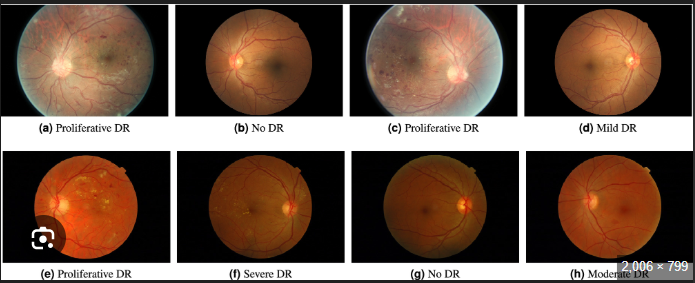


Early detection is crucial to prevent irreversible blindness.

My goal is to built a model that can predict whether or not a patient has DR, and the severerity level,the severerity level ranes from 0-4, 5 levels, with zero for normal or 'does not have the illness'


In [ ]:
# Importing basic libraries
import os
import random
import shutil
import numpy as np
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline



# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
import tensorflow as tf

from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Random seeds set: NumPy, TensorFlow, and Python random")

Random seeds set: NumPy, TensorFlow, and Python random


In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

In [ ]:
from google.colab import drive #mounting the drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/summative #check if my dataset successfully loaded


'aptos2019-blindness-detection (1).zip'


In [ ]:
!unzip -o "/content/drive/MyDrive/summative/aptos2019-blindness-detection (1).zip" -d /content/data


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test_images/512beaada8f0.png  
  inflating: /content/data/test_images/51323e9d2070.png  
  inflating: /content/data/test_images/515675001b9e.png  
  inflating: /content/data/test_images/515877da2def.png  
  inflating: /content/data/test_images/5168ddccea88.png  
  inflating: /content/data/test_images/5172c056a687.png  
  inflating: /content/data/test_images/5177461f5339.png  
  inflating: /content/data/test_images/51910bcb980d.png  
  inflating: /content/data/test_images/51a3e9b6a1c0.png  
  inflating: /content/data/test_images/51bbd82feec8.png  
  inflating: /content/data/test_images/51de5fb8eccd.png  
  inflating: /content/data/test_images/51e88694c81f.png  
  inflating: /content/data/test_images/51f0bf8f1544.png  
  inflating: /content/data/test_images/51f57fb32840.png  
  inflating: /content/data/test_images/51fa42dc1415.png  
  inflating: /content/data/test_images/5276ab33b7b0.png  
  inflating: /content

## Inspecting Dataset Contents

This step lists all extracted dataset files including:

- Training images
- Test images
- Label CSV files

This confirms correct dataset organization.


In [ ]:


!ls /content/data


sample_submission.csv  test.csv  test_images  train.csv  train_images


In [ ]:
import os

len(os.listdir('/content/data/train_images'))


3662

In [ ]:
import pandas as pd #exploring the dataset

train_df = pd.read_csv('/content/data/train.csv')
train_df.head()


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
train_df.info() #tocheck for any null vallues or empty enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [ ]:
train_df['diagnosis'].value_counts() #how often each disease level appears.


,count
diagnosis,
0,1805
2,999
1,370
4,295
3,193


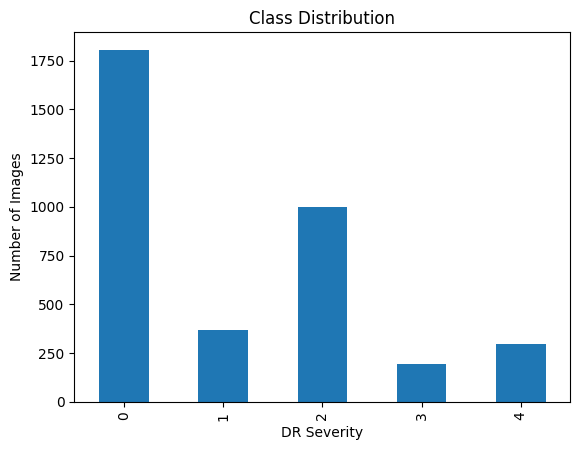

In [ ]:


#class distribution Visualize class imbalance graph
import matplotlib.pyplot as plt
train_df['diagnosis'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('DR Severity')
plt.ylabel('Number of Images')
plt.show()


(np.float64(-0.5), np.float64(3215.5), np.float64(2135.5), np.float64(-0.5))

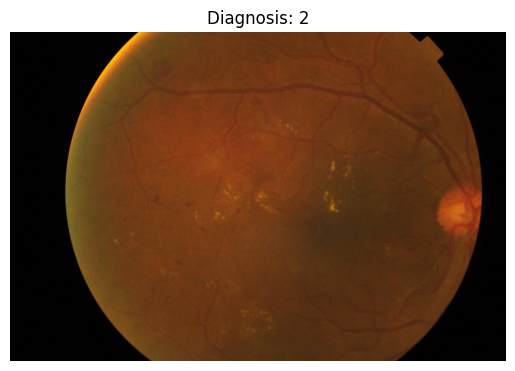

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = '/content/data/train_images/' + train_df.iloc[0,0] + '.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"Diagnosis: {train_df.iloc[0,1]}")
plt.axis('off')


In [ ]:
for batch in train_df:
    print(type(batch))
    print(len(batch))
    break


<class 'str'>
7


In [ ]:
import numpy as np
import pandas as pd # Ensure pandas is imported if not already

# Assuming train_df is already defined from a previous cell
# If train_df is not defined, you would need to load it first:
# train_df = pd.read_csv('/content/data/train.csv')

# Directly extract the 'diagnosis' column from train_df
train_labels = train_df['diagnosis'].values

print("Labels extracted successfully!")
print("Shape:", train_labels.shape)


Labels extracted successfully!
Shape: (2929,)


## Image Preprocessing and Augmentation

Images are resized and normalized to standard dimensions suitable for CNN training.

Data augmentation techniques such as flipping, rotation, and zooming are applied to increase dataset diversity and reduce overfitting.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


#splitting data into training and validation data
train_df, val_df = train_test_split(
        train_df,
        test_size = 0.2,
        stratify=train_df['diagnosis'],
        random_state=42
    )
BASE_PATH = "/content/data/train_images/"

IMG_SIZE = 224

#Preprocessing, image resizing and normalization
def preprocess_image(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))#resizingd retina images to consistent diamensions 0-255 -> 0-1
    image = preprocess_input(image)
    return image


 #data augmentation,to artificially create variations
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ])


#handling imnalance(class wights) we punsh the model more when it misclassifies rare classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels

)

class_weights = dict(enumerate(class_weights))
print(class_weights)





{0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}


In [ ]:
#apply loading function to apply a function to every dataset element
train_dataset = train_dataset.map(
    load_image,
    num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.map(
    load_image,
    num_parallel_calls=tf.data.AUTOTUNE)

#augmentation
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


## Dataset Batching and Prefetching

Batching improves training efficiency while prefetching optimizes GPU utilization. These techniques accelerate training performance.


In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .cache()
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


## Experiment 1: Traditional Machine Learning Feature Extraction

Images are resized and flattened into feature vectors suitable for traditional machine learning models. This allows comparison between classical algorithms and deep learning approaches.





## Training Logistic Regression Model

Logistic regression is trained as a baseline traditional classification model. Its performance provides a benchmark for evaluating CNN improvements.


In [ ]:
from tqdm import tqdm

X = []
y = []

print("Extracting image features...")

for index, row in tqdm(train_df.iterrows(), total=len(train_df)):

    img_path = BASE_PATH + row['id_code'] + ".png"

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (64, 64))   # Smaller size → faster traditional ML

    img = img / 255.0

    X.append(img.flatten())
    y.append(row['diagnosis'])

X = np.array(X)
y = np.array(y)

print("Feature extraction complete")
print("Feature shape:", X.shape)


Extracting image features...


100%|██████████| 2343/2343 [04:38<00:00,  8.41it/s]


Feature extraction complete
Feature shape: (2343, 12288)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Split complete")


Split complete


In [ ]:
from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression...")

log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
log_model.fit(X_train, y_train)

print("Training complete")


Training Logistic Regression...
Training complete


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       231
           1       0.41      0.38      0.40        47
           2       0.59      0.70      0.64       128
           3       0.18      0.08      0.11        25
           4       0.44      0.18      0.26        38

    accuracy                           0.72       469
   macro avg       0.50      0.46      0.47       469
weighted avg       0.69      0.72      0.70       469



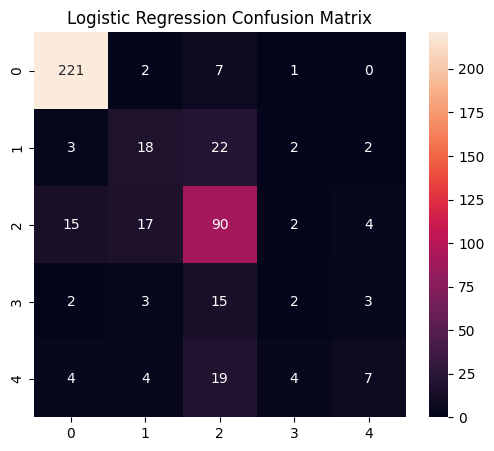

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_log = log_model.predict(X_val)

print(classification_report(y_val, y_pred_log))

cm_log = confusion_matrix(y_val, y_pred_log)

import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm_log, annot=True, fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


## Experiment 2: Random Forest Model

Random Forest is trained to improve classification using ensemble learning techniques. It captures nonlinear relationships better than logistic regression.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Training complete")


Training Random Forest...
Training complete


              precision    recall  f1-score   support

           0       0.90      0.97      0.93       231
           1       0.44      0.38      0.41        47
           2       0.56      0.73      0.64       128
           3       0.50      0.08      0.14        25
           4       0.67      0.11      0.18        38

    accuracy                           0.73       469
   macro avg       0.61      0.45      0.46       469
weighted avg       0.72      0.73      0.70       469



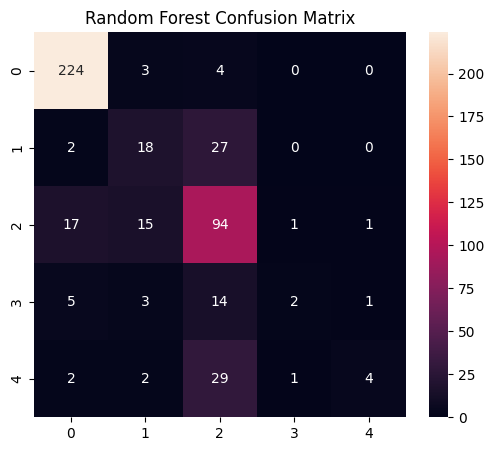

In [ ]:
y_pred_rf = rf_model.predict(X_val)

print(classification_report(y_val, y_pred_rf))

cm_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()


#done with preping the data npow ready for modeling

#CNN models

## Experiment 3: Baseline Convolutional Neural Network

A simple CNN architecture is developed to automatically learn retinal image features using convolutional and pooling layers. This serves as the first deep learning benchmark.


## Training Baseline CNN Model

The CNN is trained using categorical cross-entropy loss and accuracy metrics. Class weights are applied to improve performance on minority classes.

## Evaluating Baseline CNN Performance

Model performance is evaluated using:

- Precision
- Recall
- F1 Score
- ROC-AUC
- Quadratic Weighted Kappa
- Confusion Matrix



In [ ]:
# Create Baseline CNN Model
print("Creating Baseline CNN Model...")

# Start a Sequential model
model = tf.keras.models.Sequential()

# Layer 1: Conv2D + MaxPooling2D
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Layer 2: Conv2D + MaxPooling2D
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Layer 3: Conv2D + MaxPooling2D
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# : Adding two more convolutional blocks
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))


# safer pooling the 3D output to 1D
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Output layer (binary classification) using softmax because it is a multi class classification and not binary which goes with sigmoid
model.add(tf.keras.layers.Dense(5, activation='softmax'))

print("Baseline CNN model created!")

Creating Baseline CNN Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline CNN model created!


In [ ]:
# Show model summary
print("\nModel Summary:")
print("=" * 50)
model.summary()
print("=" * 50)


Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,634,885 (6.24 MB)

 Trainable params: 1,634,885 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(1444), np.int64(1): np.int64(296), np.int64(2): np.int64(799), np.int64(3): np.int64(154), np.int64(4): np.int64(236)}


In [ ]:
#train or 10 epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight = class_weights
)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.3622 - loss: 1.5825 - val_accuracy: 0.5034 - val_loss: 1.3959
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.4224 - loss: 1.5487 - val_accuracy: 0.5563 - val_loss: 1.3112
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.5187 - loss: 1.4422 - val_accuracy: 0.5375 - val_loss: 1.0223
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.5160 - loss: 1.3398 - val_accuracy: 0.6382 - val_loss: 0.9604
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.5620 - loss: 1.3577 - val_accuracy: 0.6502 - val_loss: 0.9722
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5880 - loss: 1.3309 - val_accuracy: 0.6706 - val_loss: 0.9245
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.5791 - loss: 1.2972 - val_accuracy: 0.5631 - val_loss: 0.9597
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.5369 - loss: 1.2779 - val_accuracy: 0.6

In [61]:
# Save the Baseline CNN Experiment 1
print("Saving Experiment 1...")

# Save the model
model.save('baseline_exp1.h5')
print("Model saved: baseline_exp1.h5")

# Save training history
import pickle
with open('baseline_history_exp1.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("History saved: baseline_history_exp1.pkl")

# Show final accuracy
final_acc = history.history['val_accuracy'][-1]
print("=================================================")
print(f"Experiment 1 Val Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")

Saving Experiment 1...
Model saved: baseline_exp1.h5
History saved: baseline_history_exp1.pkl
Experiment 1 Val Accuracy: 0.6126 (61.26%)


In [62]:
# =============================
# Proper Multi-class Evaluation
# =============================

y_true = []
y_pred = []
y_prob = []

for images, labels in val_dataset:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)   # DO NOT FLATTEN

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Weighted metrics (important for imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Quadratic Weighted Kappa (APTOS official metric)
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)
print("ROC-AUC (OVR):", roc_auc)
print("Quadratic Weighted Kappa:", qwk)


Weighted Precision: 0.6669733455143012
Weighted Recall: 0.6126279863481229
Weighted F1-score: 0.6262542988036572
ROC-AUC (OVR): 0.8283527043096006
Quadratic Weighted Kappa: 0.5536002836570336


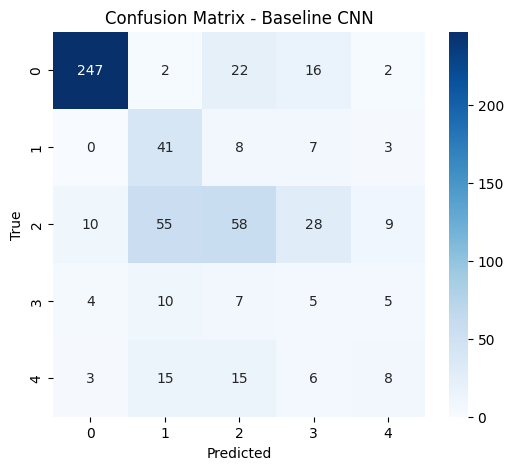

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Baseline CNN")
plt.show()


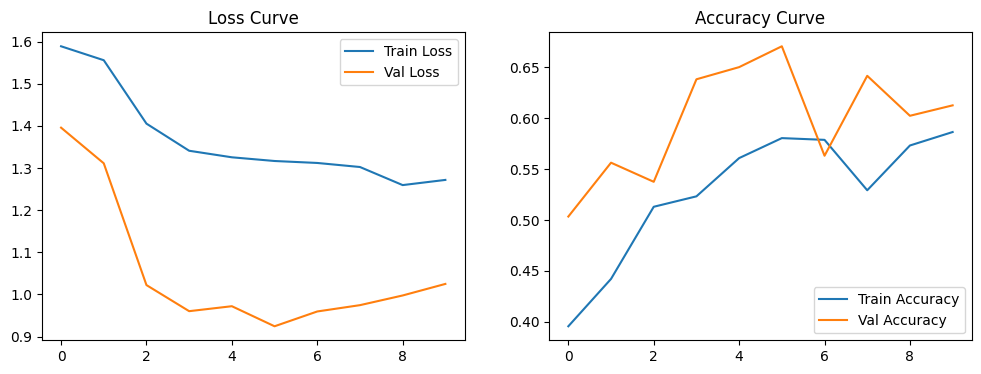

In [64]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.legend()

plt.show()


## Experiment 4: Advanced CNN Architecture

Additional convolution blocks, batch normalization, and dropout layers are introduced to improve training stability and reduce overfitting.


In [66]:
data_augmentation_advanced = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.15)
])


train_dataset_adv = train_dataset.unbatch()

train_dataset_adv = train_dataset_adv.map(
    lambda x, y: (data_augmentation_advanced(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_dataset_adv = train_dataset_adv.batch(32).prefetch(tf.data.AUTOTUNE)


In [67]:
print("Building Advanced CNN...")

advanced_model = tf.keras.Sequential([

    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # Block 4 (NEW)
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten
    tf.keras.layers.Flatten(),

    # Dense Layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Output for 5 classes
    tf.keras.layers.Dense(5, activation='softmax')
])


Building Advanced CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
advanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [69]:
history_adv = advanced_model.fit(
    train_dataset_adv,
    validation_data=val_dataset,
    epochs=15,
    class_weight=class_weights
)


Epoch 1/15
     74/Unknown 49s 470ms/step - accuracy: 0.2838 - loss: 4.6980

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 499ms/step - accuracy: 0.2837 - loss: 4.6960 - val_accuracy: 0.4659 - val_loss: 2.9267
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.2784 - loss: 3.3587 - val_accuracy: 0.3549 - val_loss: 1.5826
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 418ms/step - accuracy: 0.2488 - loss: 2.9002 - val_accuracy: 0.1553 - val_loss: 3.0705
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.2748 - loss: 2.3065 - val_accuracy: 0.4932 - val_loss: 1.7034
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 423ms/step - accuracy: 0.2669 - loss: 2.0417 - val_accuracy: 0.1075 - val_loss: 1.6881
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 443ms/step - accuracy: 0.2961 - loss: 1.6947 - val_accuracy: 0.0666 - val_loss: 1.7107
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 414ms/step - accuracy: 0.2379 - loss: 1.6941 - val_accuracy: 0.0939 - val_loss: 1.6506
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 412ms/step - accuracy: 0.2205 - loss: 1.6526 - val_accuracy: 0.081

In [70]:
# =============================
# Proper Multi-class Evaluation
# =============================

y_true = []
y_pred = []
y_prob = []

for images, labels in val_dataset:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)   # DO NOT FLATTEN

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Weighted metrics (important for imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Quadratic Weighted Kappa (APTOS official metric)
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)
print("ROC-AUC (OVR):", roc_auc)
print("Quadratic Weighted Kappa:", qwk)


Weighted Precision: 0.6669733455143012
Weighted Recall: 0.6126279863481229
Weighted F1-score: 0.6262542988036572
ROC-AUC (OVR): 0.8283527043096006
Quadratic Weighted Kappa: 0.5536002836570336


## Experiment 5: MobileNet Transfer Learning

MobileNetV2 pretrained on ImageNet is used for feature extraction. Transfer learning leverages previously learned visual features to improve classification accuracy.

## Training MobileNet Model

The pretrained base model is frozen, and custom classification layers are trained using retinal images.

## Evaluating MobileNet Performance

The model is evaluated using weighted classification metrics and clinical reliability measures such as Quadratic Weighted Kappa.


In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [72]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)



In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [74]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [75]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight = class_weights,
    epochs = 20

)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 969ms/step - accuracy: 0.3386 - loss: 1.7082 - val_accuracy: 0.6126 - val_loss: 1.1017
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5499 - loss: 1.3299 - val_accuracy: 0.6263 - val_loss: 1.0066
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5788 - loss: 1.2501 - val_accuracy: 0.6519 - val_loss: 0.9453
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5967 - loss: 1.2015 - val_accuracy: 0.6672 - val_loss: 0.9048
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6493 - loss: 1.0754 - val_accuracy: 0.6519 - val_loss: 0.8923
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6297 - loss: 1.1051 - val_accuracy: 0.6672 - val_loss: 0.8468
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6864 - loss: 1.0345 - val_accuracy: 0.6758 - val_loss: 0.8293
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7150 - loss: 0.9571 - val_accuracy: 0.6758 -

In [76]:
# =============================
# Proper Multi-class Evaluation
# =============================

y_true = []
y_pred = []
y_prob = []

for images, labels in val_dataset:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)   # DO NOT FLATTEN

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Weighted metrics (important for imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Quadratic Weighted Kappa (APTOS official metric)
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)
print("ROC-AUC (OVR):", roc_auc)
print("Quadratic Weighted Kappa:", qwk)


Weighted Precision: 0.7589709571879096
Weighted Recall: 0.7133105802047781
Weighted F1-score: 0.7241672554916849
ROC-AUC (OVR): 0.9022440166880633
Quadratic Weighted Kappa: 0.8245205665526482


## Experiment 6: Learning Rate Optimization

The learning rate is reduced to improve fine-tuning stability. Lower learning rates help preserve pretrained feature knowledge while adapting to retinal data.


In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [78]:
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - accuracy: 0.8085 - loss: 0.7152 - val_accuracy: 0.7116 - val_loss: 0.7363
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7799 - loss: 0.7140 - val_accuracy: 0.7133 - val_loss: 0.7320
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7727 - loss: 0.7153 - val_accuracy: 0.7116 - val_loss: 0.7316
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7798 - loss: 0.7219 - val_accuracy: 0.7116 - val_loss: 0.7352
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7879 - loss: 0.7066 - val_accuracy: 0.7082 - val_loss: 0.7345
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7915 - loss: 0.6918 - val_accuracy: 0.7133 - val_loss: 0.7374
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7848 - loss: 0.6871 - val_accuracy: 0.7150 - val_loss: 0.7353
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7831 - loss: 0.6777 - val_accuracy: 0.7133 -

In [79]:
# =============================
# Proper Multi-class Evaluation
# =============================

y_true = []
y_pred = []
y_prob = []

for images, labels in val_dataset:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)   # DO NOT FLATTEN

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Weighted metrics (important for imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Quadratic Weighted Kappa (APTOS official metric)
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)
print("ROC-AUC (OVR):", roc_auc)
print("Quadratic Weighted Kappa:", qwk)


Weighted Precision: 0.7589360940125233
Weighted Recall: 0.7098976109215017
Weighted F1-score: 0.7185567435343077
ROC-AUC (OVR): 0.9033325417786549
Quadratic Weighted Kappa: 0.8182449730672137


#Visualizations for best model


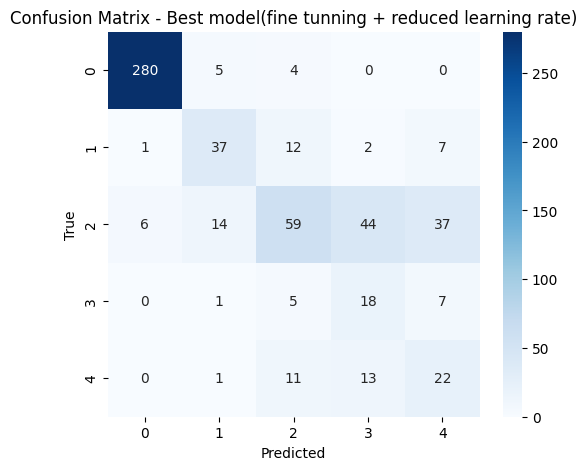

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Best model(fine tunning + reduced learning rate)")
plt.show()


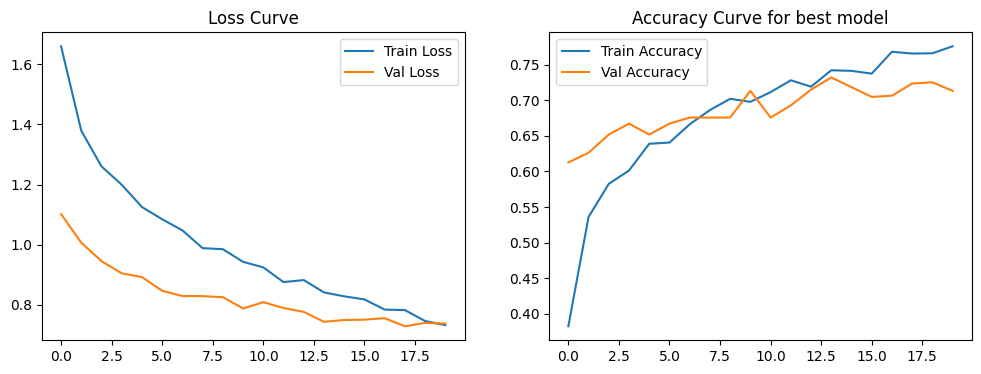

In [81]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve for best model")
plt.legend()

plt.show()


## Experiment 7: Partial Fine Tuning

Selected layers of MobileNet are unfrozen to allow deeper feature adaptation. This experiment tests whether additional training improves classification performance.




In [82]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False



In [83]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [87]:
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights,
    epochs=20
)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 605ms/step - accuracy: 0.5626 - loss: 1.2655 - val_accuracy: 0.7304 - val_loss: 0.6942
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6488 - loss: 1.0657 - val_accuracy: 0.7389 - val_loss: 0.6714
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6845 - loss: 0.9178 - val_accuracy: 0.7440 - val_loss: 0.6604
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7097 - loss: 0.9098 - val_accuracy: 0.7355 - val_loss: 0.6589
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.7315 - loss: 0.7975 - val_accuracy: 0.7321 - val_loss: 0.6570
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.7832 - loss: 0.7180 - val_accuracy: 0.7304 - val_loss: 0.6542
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.7581 - loss: 0.7067 - val_accuracy: 0.7304 - val_loss: 0.6581
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.7957 - loss: 0.6489 - val_accuracy: 0.730

In [88]:

# Proper Multi-class Evaluation
#

y_true = []
y_pred = []
y_prob = []

for images, labels in val_dataset:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)   # DO NOT FLATTEN

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Weighted metrics (important for imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Quadratic Weighted Kappa (APTOS official metric)
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)
print("ROC-AUC (OVR):", roc_auc)
print("Quadratic Weighted Kappa:", qwk)


Weighted Precision: 0.7496307961819323
Weighted Recall: 0.7474402730375427
Weighted F1-score: 0.7325402518334977
ROC-AUC (OVR): 0.9195692541018161
Quadratic Weighted Kappa: 0.7718764916234341


## Final Model Evaluation

All models are compared using multiple evaluation metrics to determine the best performing architecture for diabetic retinopathy detection.
